In [1]:
import os
os.chdir("..")
os.getcwd()

'/home/bbd0953/diffusion/src'

In [2]:
from pathlib import Path

import numpy as np
import torch
from torchvision.transforms import ToTensor, Compose, CenterCrop
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

from utils.data_utils import ImagePathDataset, LofarSubset, lofar_transform
from utils.plot_utils import plot_samples, plot_distributions
from analysis.model_evaluations import get_distributions, per_bin_error


Methods:
- Consider FID
- Find closest matching pairs
- normalized histograms of:
    - pixel intensities
    - number of pixels with an intensity greater than zero
    - the sum of intensities
- RMAE for distributions (difference / sum for each bin)

Attention!
- Images should be scaled between 0 and 1 

# Datasets

## Load:

### LOFAR Whole Set

In [10]:
transform = Compose([
        ToTensor(),
        CenterCrop(80),
    ])

ds_lofar = LofarUnlabeled("./data", las_thr=[40, 120], flux_thr=5,
                            transform=transform)

Loading images...


100%|██████████| 84411/84411 [02:05<00:00, 671.00it/s]  

Data set initialized.


### Lofar Subset:

In [3]:
subset_folder = Path("/storage/tmartinez/image_data/lofar_subset")

ds_subset = LofarSubset()

Loading images...


100%|███████████████████████████████████| 84411/84411 [00:17<00:00, 4856.95it/s]

Data set initialized.


### LOFAR random 10k picks:

In [26]:
# Generate by copying files
import random
import shutil

subset_folder = Path("./data/lofar_subset")

n_folders = 2
n_files = 10000
files = sorted(subset_folder.iterdir())

sample = random.sample(files, n_folders * n_files)

for i in range(n_folders):
    out_folder = Path(f"./data/lofar_rand10k_{i}")
    Path.mkdir(out_folder)
    files = sample[i*n_files : (i + 1)*n_files]
    for f in tqdm(files):
        shutil.copy(f, out_folder.joinpath(f.name))
    


100%|██████████| 10000/10000 [00:02<00:00, 3826.99it/s]


### Generated

#### Diffusion v1.0

In [4]:
gen_folder = Path("/storage/tmartinez/image_data/generated/diffusion_v1.0")

transform = Compose([
        ToTensor(),
        CenterCrop(80),
        lambda img: img[:1,:,:],  # First channel only
    ])

ds_gen = ImagePathDataset(gen_folder, transform)

Loading images...


100%|███████████████████████████████████| 13500/13500 [00:04<00:00, 3038.97it/s]

Data set initialized.


#### Diffusion v1.0 with DDIM sampling

In [33]:
from astropy.stats import sigma_clipped_stats
from utils import clip_and_rescale

gen_folder = Path("./data/generated/diffusion_v1.0_DDIM")


transform = Compose([
        ToTensor(),
        CenterCrop(80),
        lambda img: img[:1,:,:],  # First channel only
    ])

ds_DDIM = ImagePathDataset(gen_folder, transform)

Loading images...


100%|██████████| 13500/13500 [00:02<00:00, 5201.88it/s]

Data set initialized.


#### EDM Diffusion T=50

In [4]:
gen_folder = Path("/home/bbd0953/diffusion/image_data/generated/samples_InitModel_EDM")

transform = Compose([
        ToTensor(),
        CenterCrop(80),
        lambda img: img[:1,:,:],  # First channel only
    ])

ds = ImagePathDataset(gen_folder, transforms=transform)
dl = DataLoader(ds, batch_size=36, shuffle=True)

Loading images...


100%|███████████████████████████████████| 13824/13824 [00:02<00:00, 5333.89it/s]

Data set initialized.


Loading images...


100%|███████████████████████████████████| 13824/13824 [00:02<00:00, 5920.80it/s]


Data set initialized.


Calculating distributions...: 100%|██████████| 28/28 [00:02<00:00, 10.42it/s]


Loading images...


100%|███████████████████████████████████| 84411/84411 [00:16<00:00, 5114.38it/s]


Data set initialized.


Calculating distributions...: 100%|██████████| 169/169 [00:31<00:00,  5.41it/s]


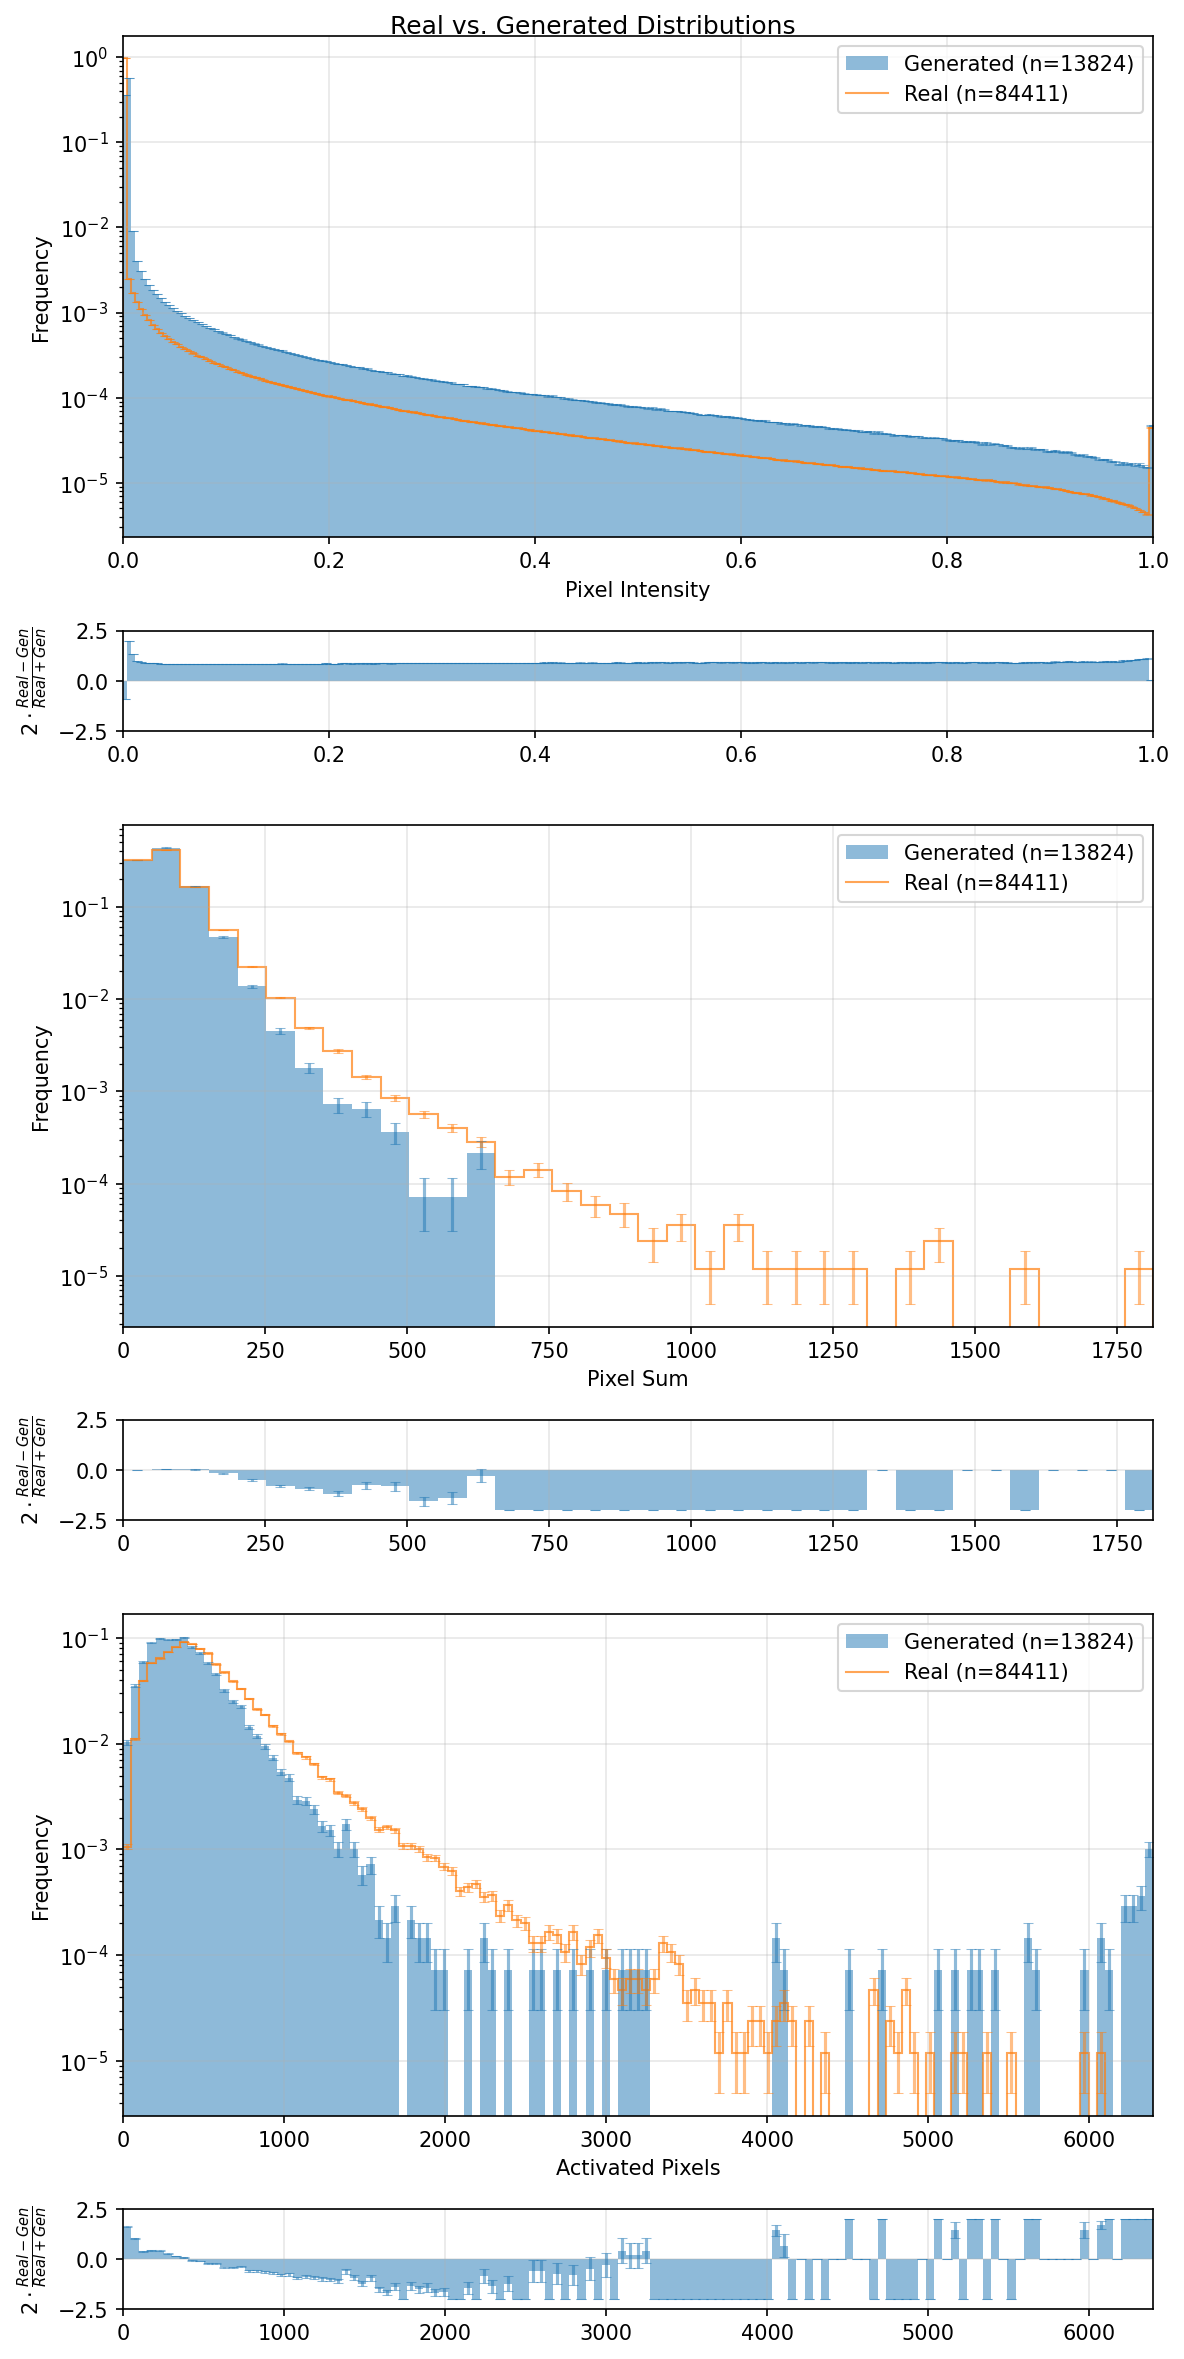

In [8]:
thr = 2/256

dist_gen, n_gen = get_distributions(gen_folder, act_threshold=thr, save=False)
dist_lofar, n_lofar = get_distributions(subset_folder, act_threshold=thr, save=False)
error = per_bin_error(dist_gen, dist_lofar)

fig = plot_distributions(dist_gen, dist_lofar, error, n_gen, n_lofar)
fig.show()

In [22]:
# Sort images by number of pixels with value > 0
n_pixels = []
for img in ds:
    n_pixels.append((img > 0).sum())

n_pixels = np.array(n_pixels)
idx = np.argsort(n_pixels)
n_pixels = n_pixels[idx]

get_upper = lambda n: torch.Tensor(np.array([ds[idx[-i]] for i in reversed(range(0, n))]))

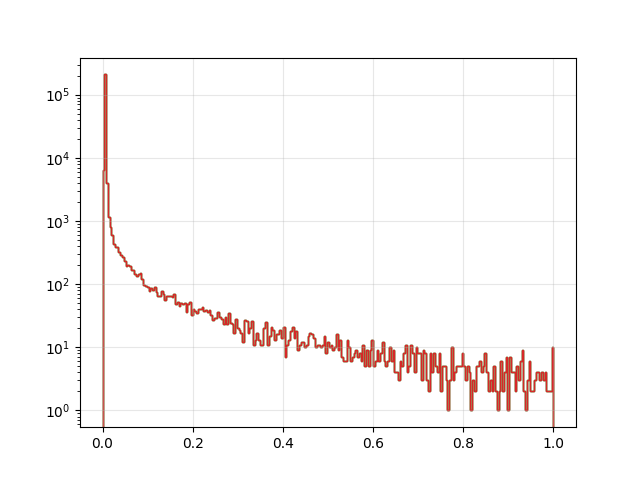

In [28]:
n = 36
imgs = get_upper(n)

# Plot pixel value distributions for upper n
%matplotlib widget
bins = torch.Tensor(np.linspace(0, 1, 256, endpoint=True))
counts, bins = torch.histogram(imgs, bins=bins)
plt.stairs(counts, bins)
plt.yscale("log")
plt.grid(alpha=0.3)
plt.show()

In [18]:
imgs[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

# Analysis & Evaluation

## Full optimization evaluation

In [3]:
from pathlib import Path
from analysis.model_evaluations import image_data_evaluation

### Diffusion v1.0

Found existing distribution file for diffusion_v1.0.
Found existing distribution file for diffusion_v1.0.
Found existing distribution file for lofar_subset.
Found existing FID stats file for diffusion_v1.0.
Found existing FID stats file for lofar_subset.
Found existing W1 score file for diffusion_v1.0.


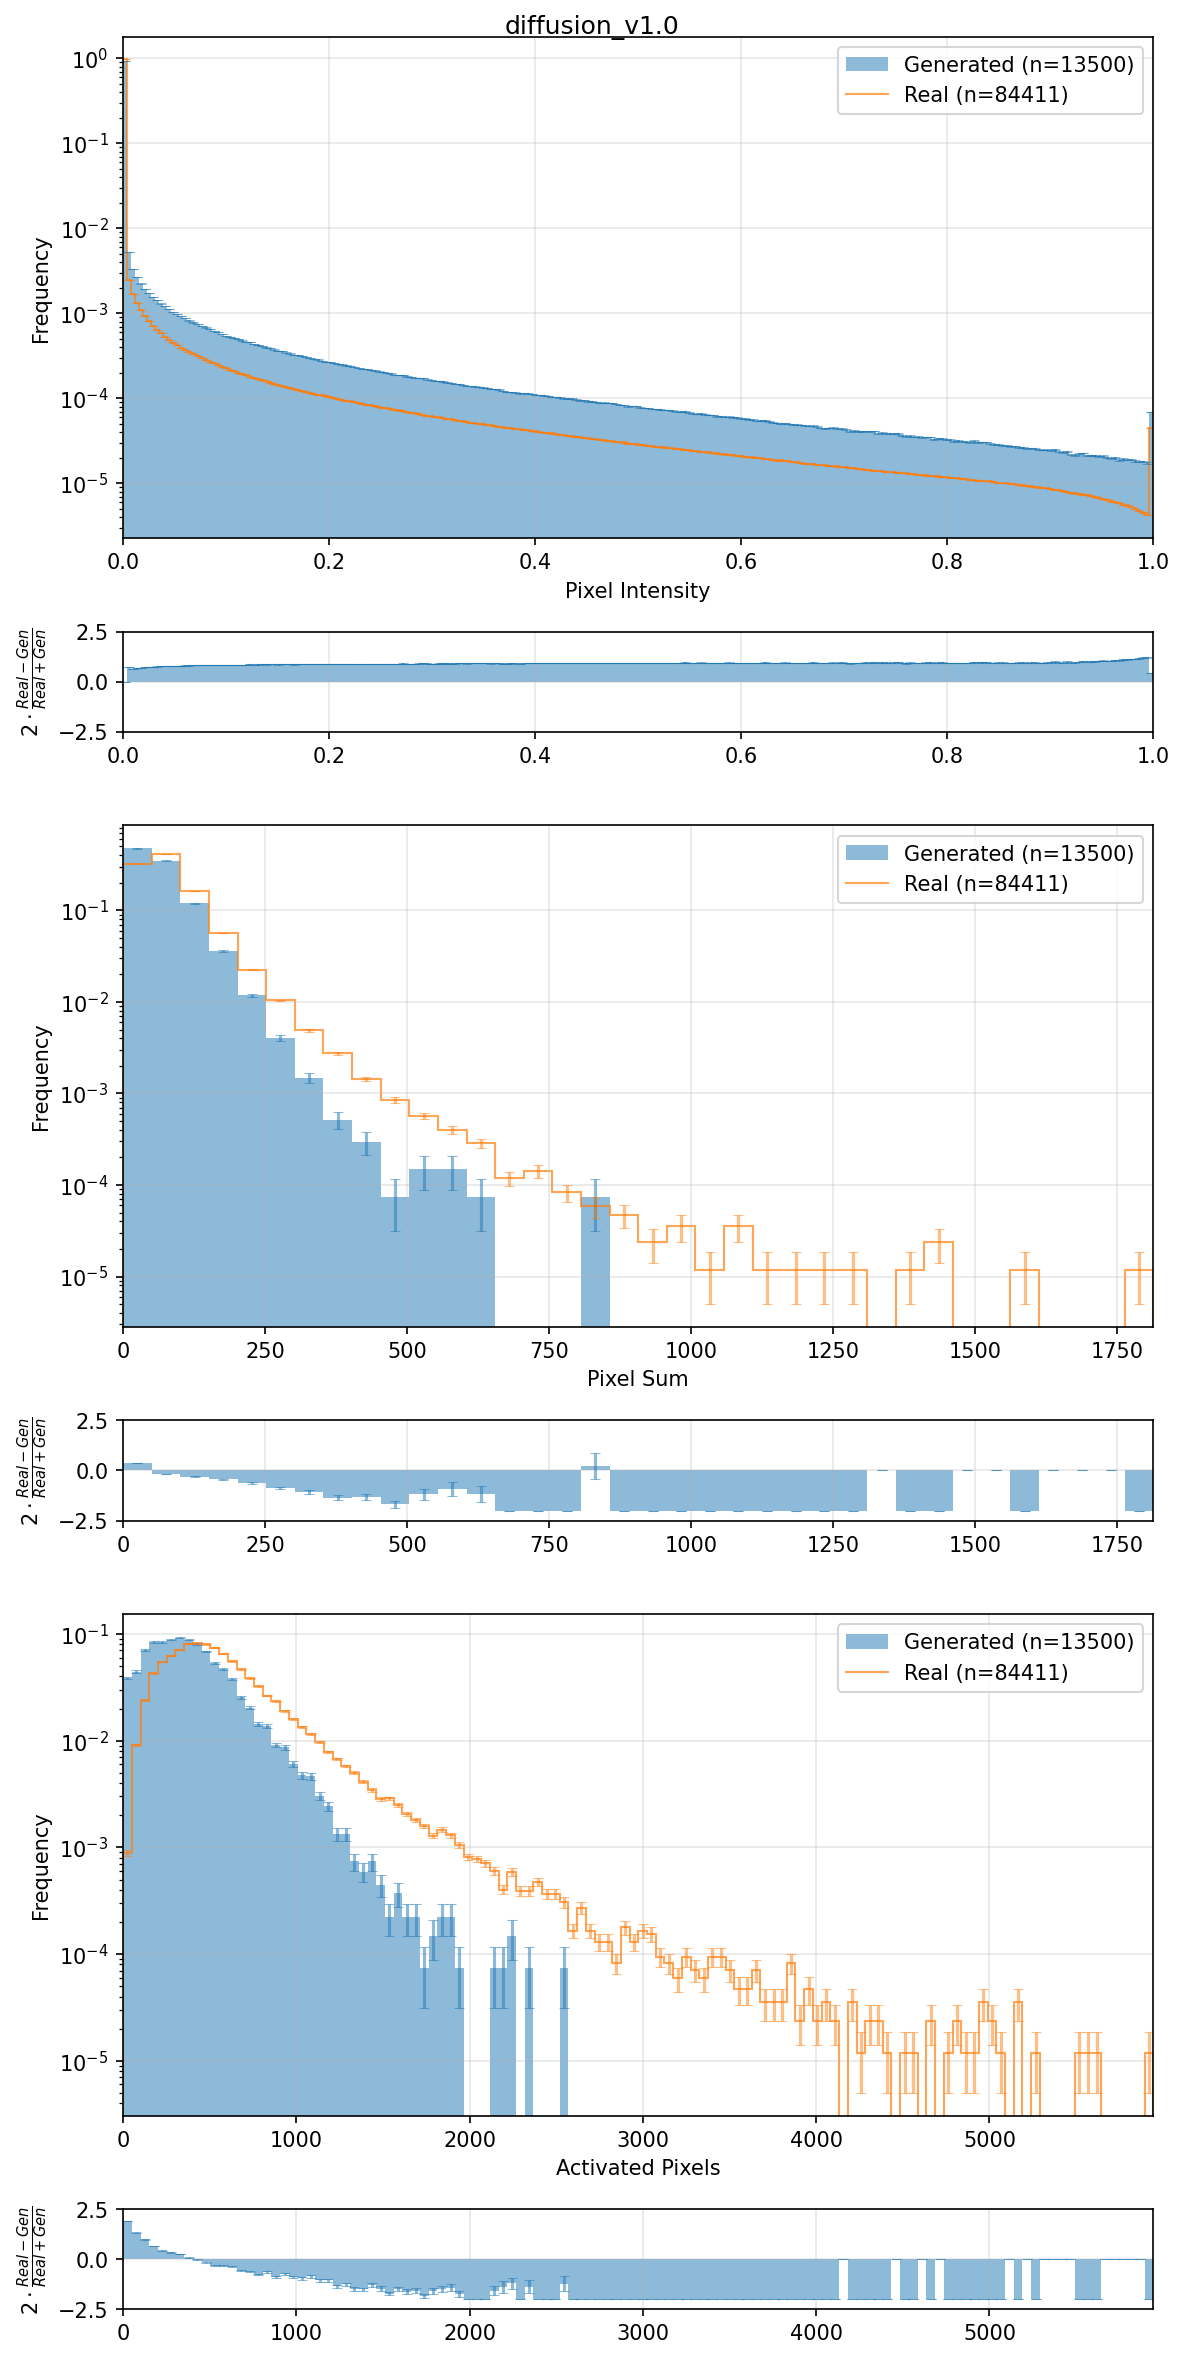

In [4]:
img_dir = Path("/home/bbd0953/diffusion/image_data/generated/diffusion_v1.0")

image_data_evaluation(img_dir);

### Diffusion v1 DDIM

Found existing distribution file for diffusion_v1.0_DDIM.
Found existing distribution file for diffusion_v1.0_DDIM.
Found existing distribution file for lofar_subset.
Found existing FID stats file for diffusion_v1.0_DDIM.
Found existing FID stats file for lofar_subset.
Found existing W1 score file for diffusion_v1.0_DDIM.


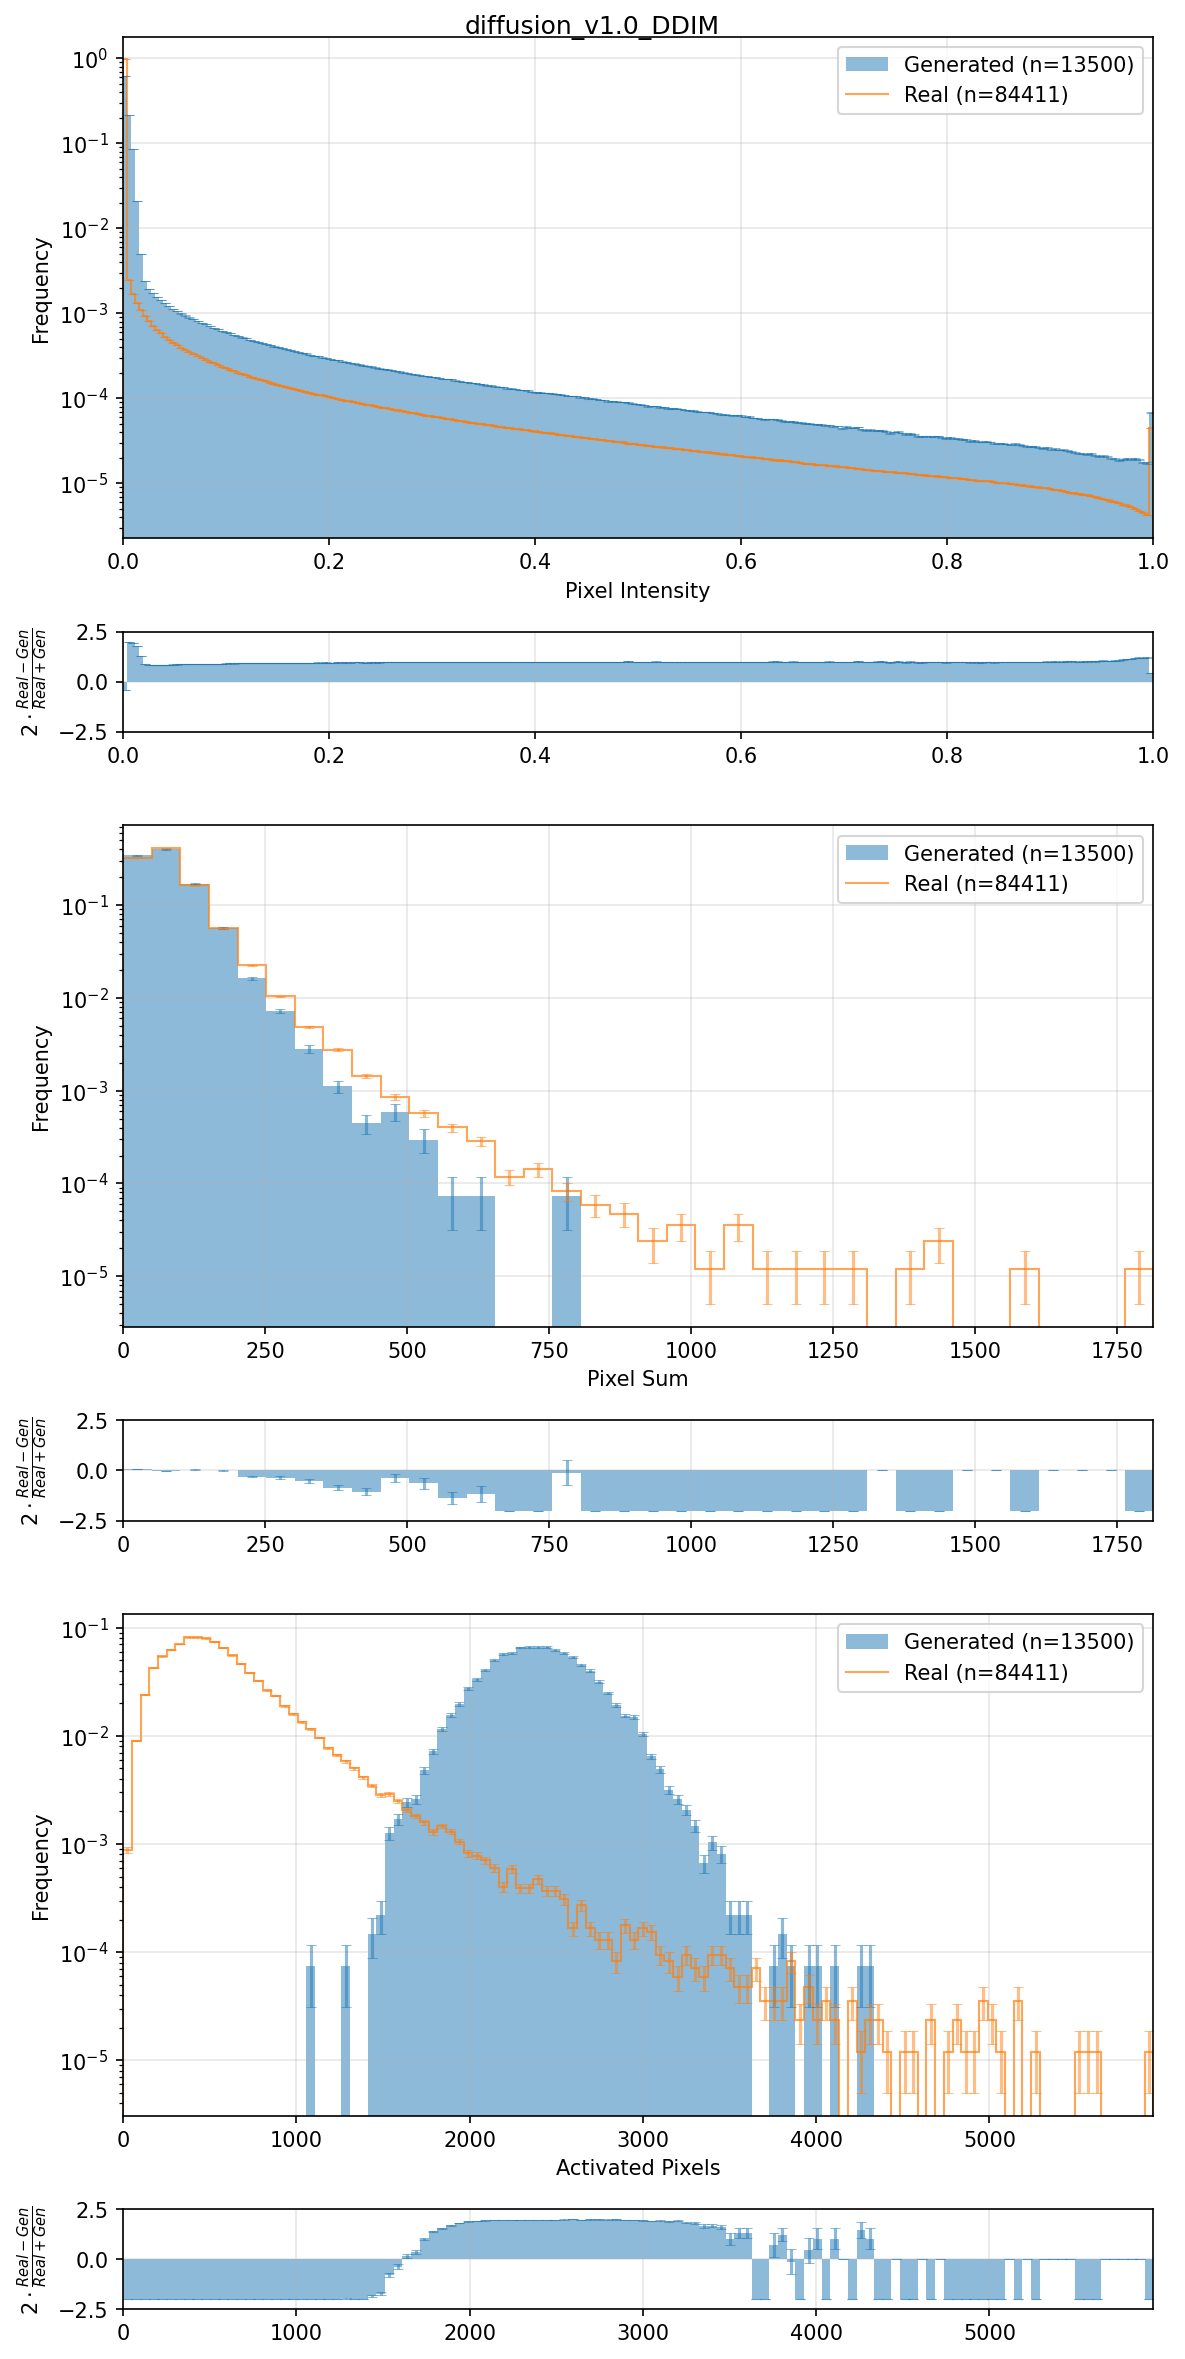

In [5]:
img_dir = Path("/home/bbd0953/diffusion/image_data/generated/diffusion_v1.0_DDIM")

image_data_evaluation(img_dir);

### InitModel_EDM (T=50)

Found existing distribution file for samples_InitModel_EDM.
Found existing distribution file for samples_InitModel_EDM.
Found existing distribution file for lofar_subset.
Found existing FID stats file for samples_InitModel_EDM.
Found existing FID stats file for lofar_subset.
Found existing W1 score file for samples_InitModel_EDM.


(<Figure size 1200x2400 with 6 Axes>,
 2761.840404064442,
 {'Pixel Intensity': 0.0031401591660049633,
  'Pixel Sum': 0.000521216235308281,
  'Activated Pixels': 0.006778063988471198})

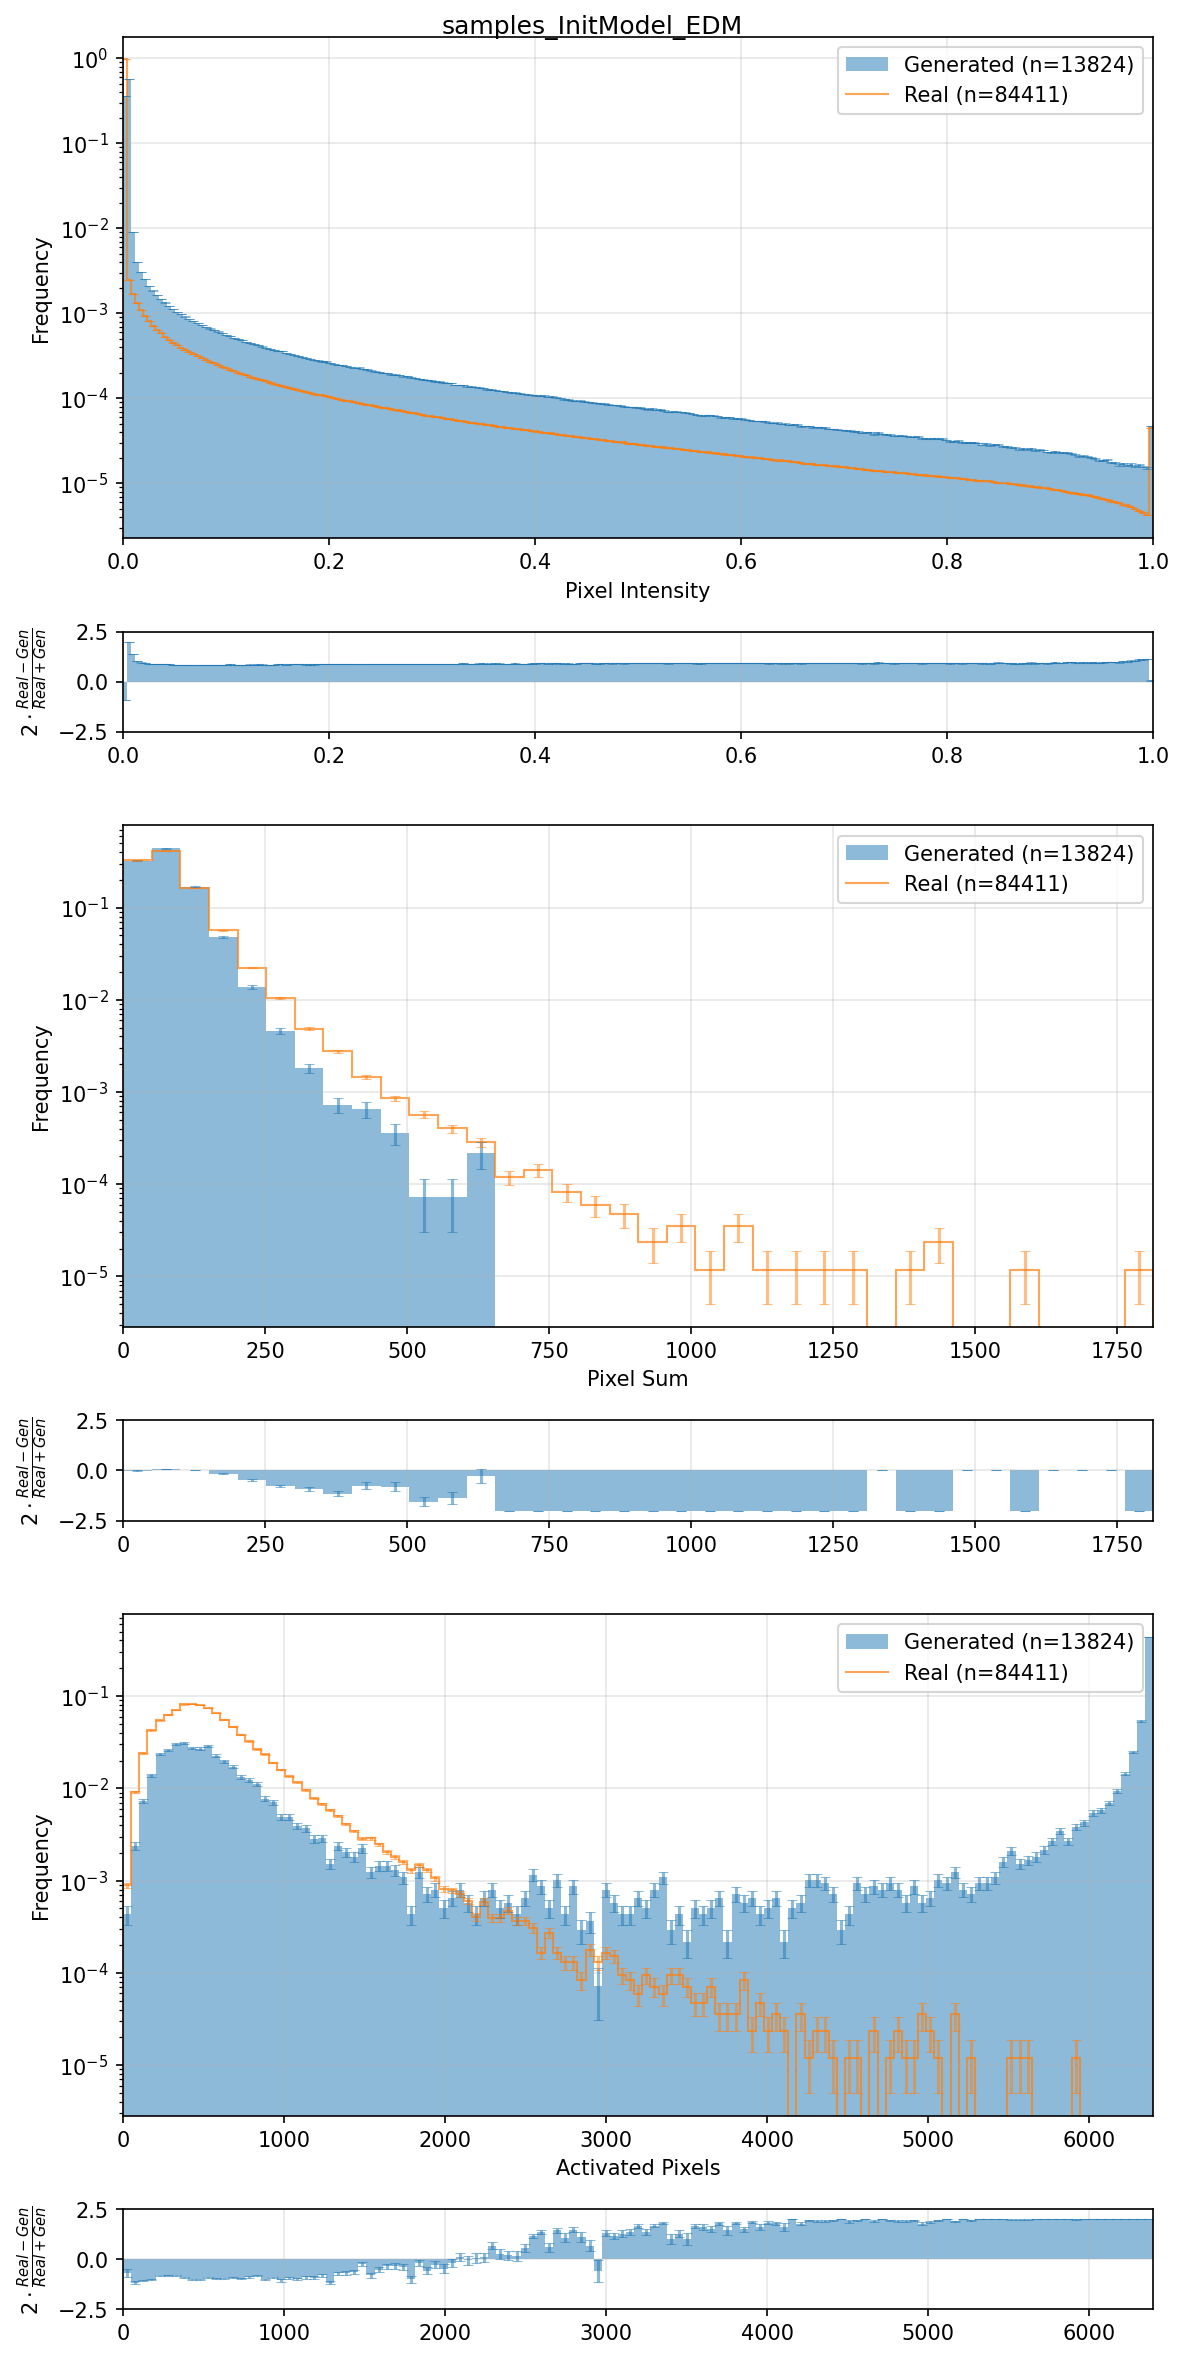

In [6]:

img_dir = Path("/home/bbd0953/diffusion/image_data/generated/samples_InitModel_EDM")
image_data_evaluation(img_dir)

### InitModel_EDM (T=1000)

Found existing distribution file for samples_InitModel_EDM_T=1000.
Found existing distribution file for samples_InitModel_EDM_T=1000.
Found existing distribution file for lofar_subset.
Found only 1536 images in /home/bbd0953/diffusion/image_data/generated/samples_InitModel_EDM_T=1000. No FID score will be calculated.
Found existing W1 score file for samples_InitModel_EDM_T=1000.


(<Figure size 1200x2400 with 6 Axes>,
 None,
 {'Pixel Intensity': 0.003163984064226355,
  'Pixel Sum': 0.0008527175134334785,
  'Activated Pixels': 0.00657923777701606})

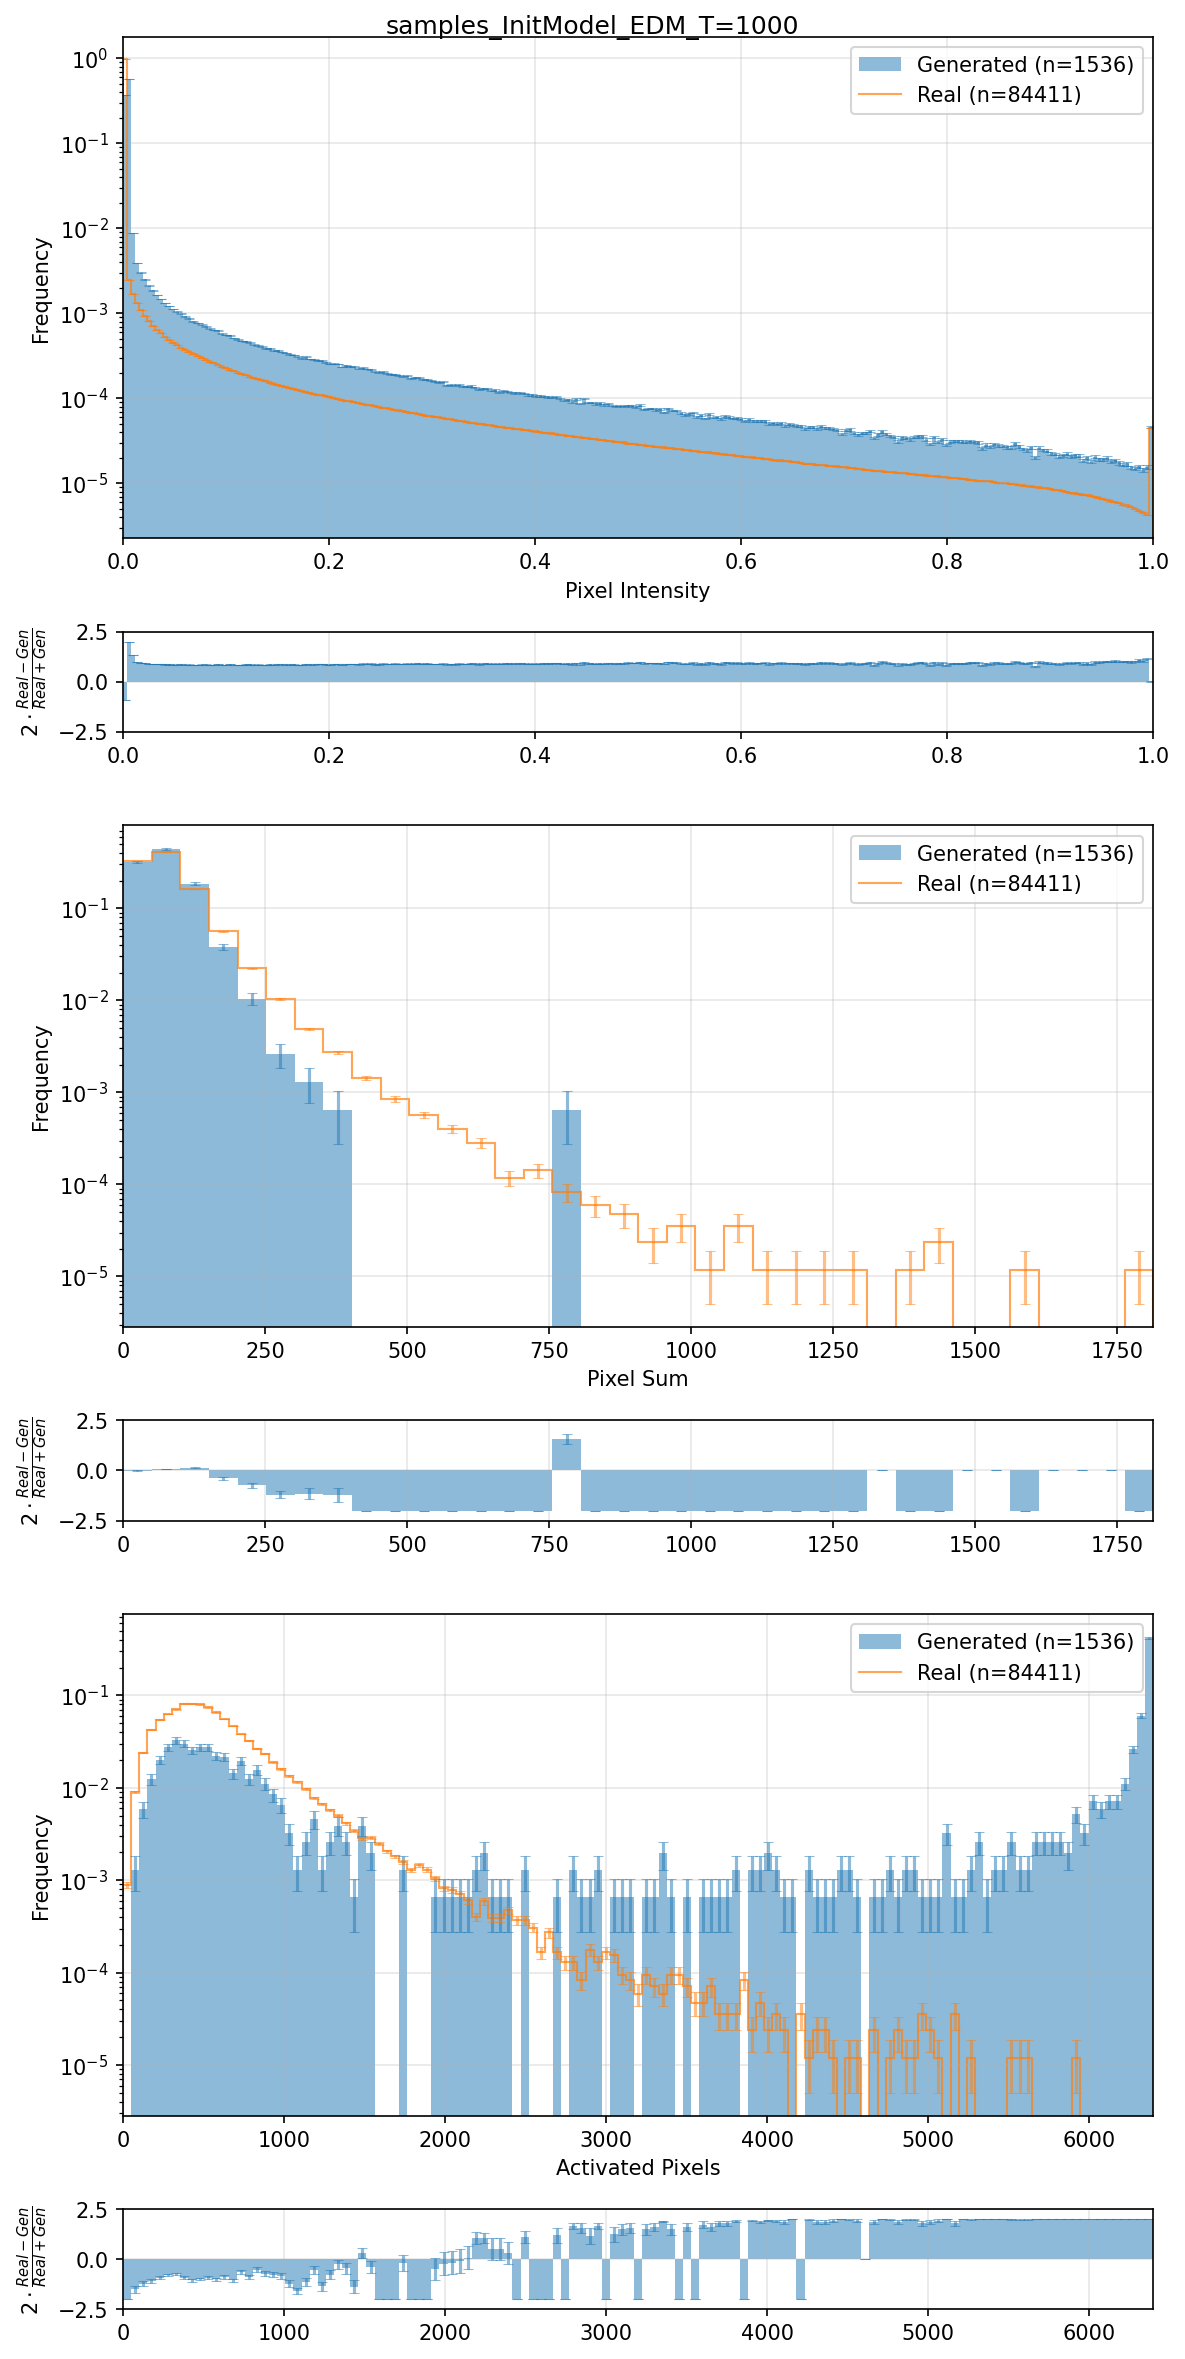

In [7]:

img_dir = Path("/home/bbd0953/diffusion/image_data/generated/samples_InitModel_EDM_T=1000")
image_data_evaluation(img_dir)

## FID

In [13]:
from analysis.model_evaluations import calculate_FID_lofar, get_FID_stats
from pathlib import Path


img_dir = Path("/storage/tmartinez/image_data/generated/diffusion_v1.0")

fid = calculate_FID_lofar(img_dir)
fid

Saving statistics for /storage/tmartinez/image_data/generated/diffusion_v1.0


100%|██████████| 211/211 [00:07<00:00, 29.08it/s]


Saving statistics for /storage/tmartinez/image_data/lofar_subset


100%|██████████| 1319/1319 [00:46<00:00, 28.22it/s]


27.005545630475424

Save FID stats of original

In [12]:
from analysis.fid_score import save_fid_stats

lofar_img_path = Path("/storage/tmartinez/image_data/lofar_subset")
# For some reason, relative paths don't work here.
out_file = Path("/storage/tmartinez/image_data/lofar_subset/lofar_subset_fid_stats")

save_fid_stats([str(lofar_img_path), str(out_file)],
                device=torch.device("cuda:1"),
                batch_size=64, dims=2048)


Saving statistics for /storage/tmartinez/image_data/lofar_subset


 15%|█▌        | 199/1319 [00:07<00:40, 27.81it/s]


KeyboardInterrupt: 

Validation with original 10k random picks:

In [11]:
rand0 = Path("/storage/tmartinez/image_data/lofar_rand10k_1/")
rand1 = Path("/storage/tmartinez/image_data/lofar_rand10k_0/")

fid_self = calculate_fid_given_paths([str(rand0), str(rand1)],
                          device=torch.device("cuda:1"),
                          batch_size=64, dims=2048)
print(fid_self)


100%|██████████| 157/157 [00:08<00:00, 18.35it/s]


0.5681567514369874


DDPM

In [3]:
from analysis.fid_score import calculate_fid_given_paths
import torch
from pathlib import Path

lofar_fid_file = Path("/home/bbd0953/diffusion/image_data/lofar_subset/lofar_subset_fid_stats.npz")
gen_img_path = Path("/storage/tmartinez/image_data/generated/diffusion_v1.0")

fid_gen = calculate_fid_given_paths([str(lofar_fid_file), str(gen_img_path)],
                          device=torch.device("cuda:1"),
                          batch_size=64, dims=2048)

100%|██████████| 211/211 [00:07<00:00, 28.23it/s]


DDIM

In [4]:
import torch

lofar_fid_file = Path("/home/bbd0953/diffusion/image_data/lofar_subset/lofar_subset_fid_stats.npz")
DDIM_img_path = Path("/storage/tmartinez/image_data/generated/diffusion_v1.0_DDIM")

fid_DDIM = calculate_fid_given_paths([str(lofar_fid_file), str(DDIM_img_path)],
                          device=torch.device("cuda:1"),
                          batch_size=64, dims=2048)

100%|██████████| 211/211 [00:06<00:00, 31.09it/s]


In [6]:
print(fid_DDIM, fid_gen)

43.70423637741874 27.005545630475467


In [9]:
print(fid_DDIM, fid_gen)

43.70423637741874 5825.443054464293


In [19]:
print(fid_DDIM, fid_gen)

43.70423637741874 27.005545630475467


## Distributions

### Utils

In [33]:
from analysis.model_evaluations import *

def get_activation_distribution(dataset, *, n_thresholds, thr_upper_lim):
    # Load data
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=500, shuffle=False, num_workers=1, drop_last=False
    )
    
    act_bins = torch.tensor(
        np.linspace(0, 6400, num=6400//50, endpoint=True)
    ).to(torch.float32)
        
    get_nbins = lambda bins: bins if isinstance(bins, int) else len(bins) - 1
    thresholds = np.linspace(0, thr_upper_lim, num=n_thresholds, endpoint=False)
    # act_hist = torch.zeros(get_nbins(act_bins)).to('cuda:0')
    histograms = torch.zeros(n_thresholds, get_nbins(act_bins)).to('cuda:0')

    for img in tqdm(dataloader, desc="Calculating distributions..."):
        img.to('cuda:0')
        for i, thr in enumerate(thresholds):
            # Activated pixels
            n_act = torch.sum((img>thr).squeeze(), [-2, -1]).to(torch.float32)  # Shape: [b]
            act_count, act_edges = torch.histogram(n_act, bins=act_bins)
            histograms[i] = torch.add(histograms[i], act_count.to('cuda:0'))

    histograms = histograms.cpu()
    return histograms, act_edges, thresholds

def plot_activation_distributions(histograms, bins):
    return
    

In [37]:
histograms, bins, thresholds = get_activation_distribution(
    ds_subset, n_thresholds=20, thr_upper_lim=.25)

Calculating distributions...: 100%|██████████| 169/169 [02:12<00:00,  1.28it/s]


In [35]:
thresholds

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225])

Text(0, 0.5, 'Threshold')

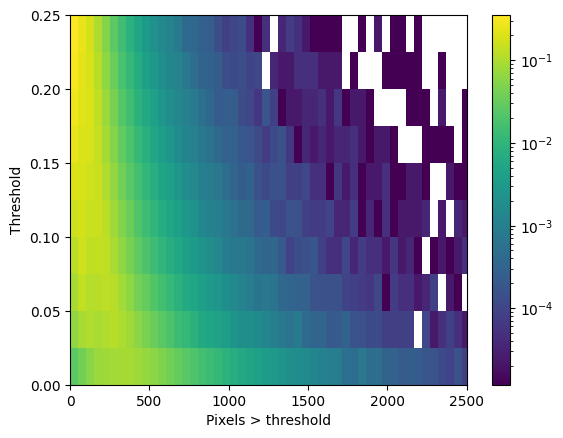

In [36]:
from matplotlib.colors import LogNorm

norm_hist = histograms / torch.sum(histograms, dim=1, keepdim=True)
lower_lim = thresholds[0]
upper_lim = thresholds[-1] + (thresholds[1] - thresholds[0])

plt.colorbar(plt.imshow(norm_hist.numpy()[::-1],
           extent=[bins[0], bins[-1], lower_lim, upper_lim],
            aspect='auto', norm=LogNorm()))
plt.xlim(0, 2500)
plt.xlabel("Pixels > threshold")
plt.ylabel("Threshold")

In [48]:
histograms[0]

tensor([2.0880e+03, 3.2840e+03, 4.8200e+03, 6.1850e+03, 6.7310e+03, 7.1130e+03,
        7.2630e+03, 7.2780e+03, 6.7050e+03, 5.8720e+03, 4.9590e+03, 4.1010e+03,
        3.3120e+03, 2.6520e+03, 2.1500e+03, 1.7160e+03, 1.3870e+03, 1.1610e+03,
        9.4500e+02, 7.6500e+02, 6.1300e+02, 4.9900e+02, 4.0700e+02, 3.6400e+02,
        2.9000e+02, 2.5600e+02, 2.0700e+02, 1.6000e+02, 1.4900e+02, 1.3200e+02,
        1.1200e+02, 9.2000e+01, 8.3000e+01, 7.5000e+01, 4.3000e+01, 4.1000e+01,
        6.0000e+01, 4.0000e+01, 4.3000e+01, 2.6000e+01, 2.5000e+01, 1.9000e+01,
        2.1000e+01, 2.0000e+01, 1.6000e+01, 1.4000e+01, 1.0000e+01, 8.0000e+00,
        1.3000e+01, 7.0000e+00, 7.0000e+00, 7.0000e+00, 2.0000e+00, 5.0000e+00,
        7.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00, 6.0000e+00, 4.0000e+00,
        3.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 4.0000e+00, 3.0000e+00,
        5.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+

### Compare LOFAR and Generated

Generate distributions:

In [8]:
bsize = 500
get_dl = lambda ds: DataLoader(ds, batch_size=bsize)

dl_lofar = get_dl(ds_subset)
dl_gen = get_dl(ds_gen)

distr_lofar = get_distributions(dl_lofar,)
                                # pixsum_bins=pixsum_bins,
                                # act_bins=act_bins)

Calculating distributions...: 100%|██████████| 169/169 [00:19<00:00,  8.86it/s]


In [21]:
torch.save(distr_lofar, "../image_data/lofar_subset/lofar_subset_distr.pt")

In [9]:
distr_gen = get_distributions(dl_gen,)

Calculating distributions...: 100%|██████████| 27/27 [00:01<00:00, 13.87it/s]


In [19]:
#Wasserstein distance
from scipy.stats import wasserstein_distance

def wasserstein_distances(distr1, distr2):
    assert distr1.keys() == distr2.keys()
    out = {}
    for key in distr1.keys():
        C1, edges = distr1[key]
        C2, _ = distr2[key]
        out[key] = wasserstein_distance(C1 / C1.sum(), C2 / C2.sum())
    
    return out

W1_dict = wasserstein_distances(distr_lofar, distr_gen)

# Print W1 dict with 2 figures scientific notation
for key in W1_dict:
    print(f"{key}: {W1_dict[key]:.2e}")


Pixel Intensity: 6.68e-05
Pixel Sum: 5.39e-04
Activated Pixels: 8.21e-04


In [15]:
error = per_bin_error(distr_lofar, distr_gen)
rmae = RMAE(error)

Plot distributions:

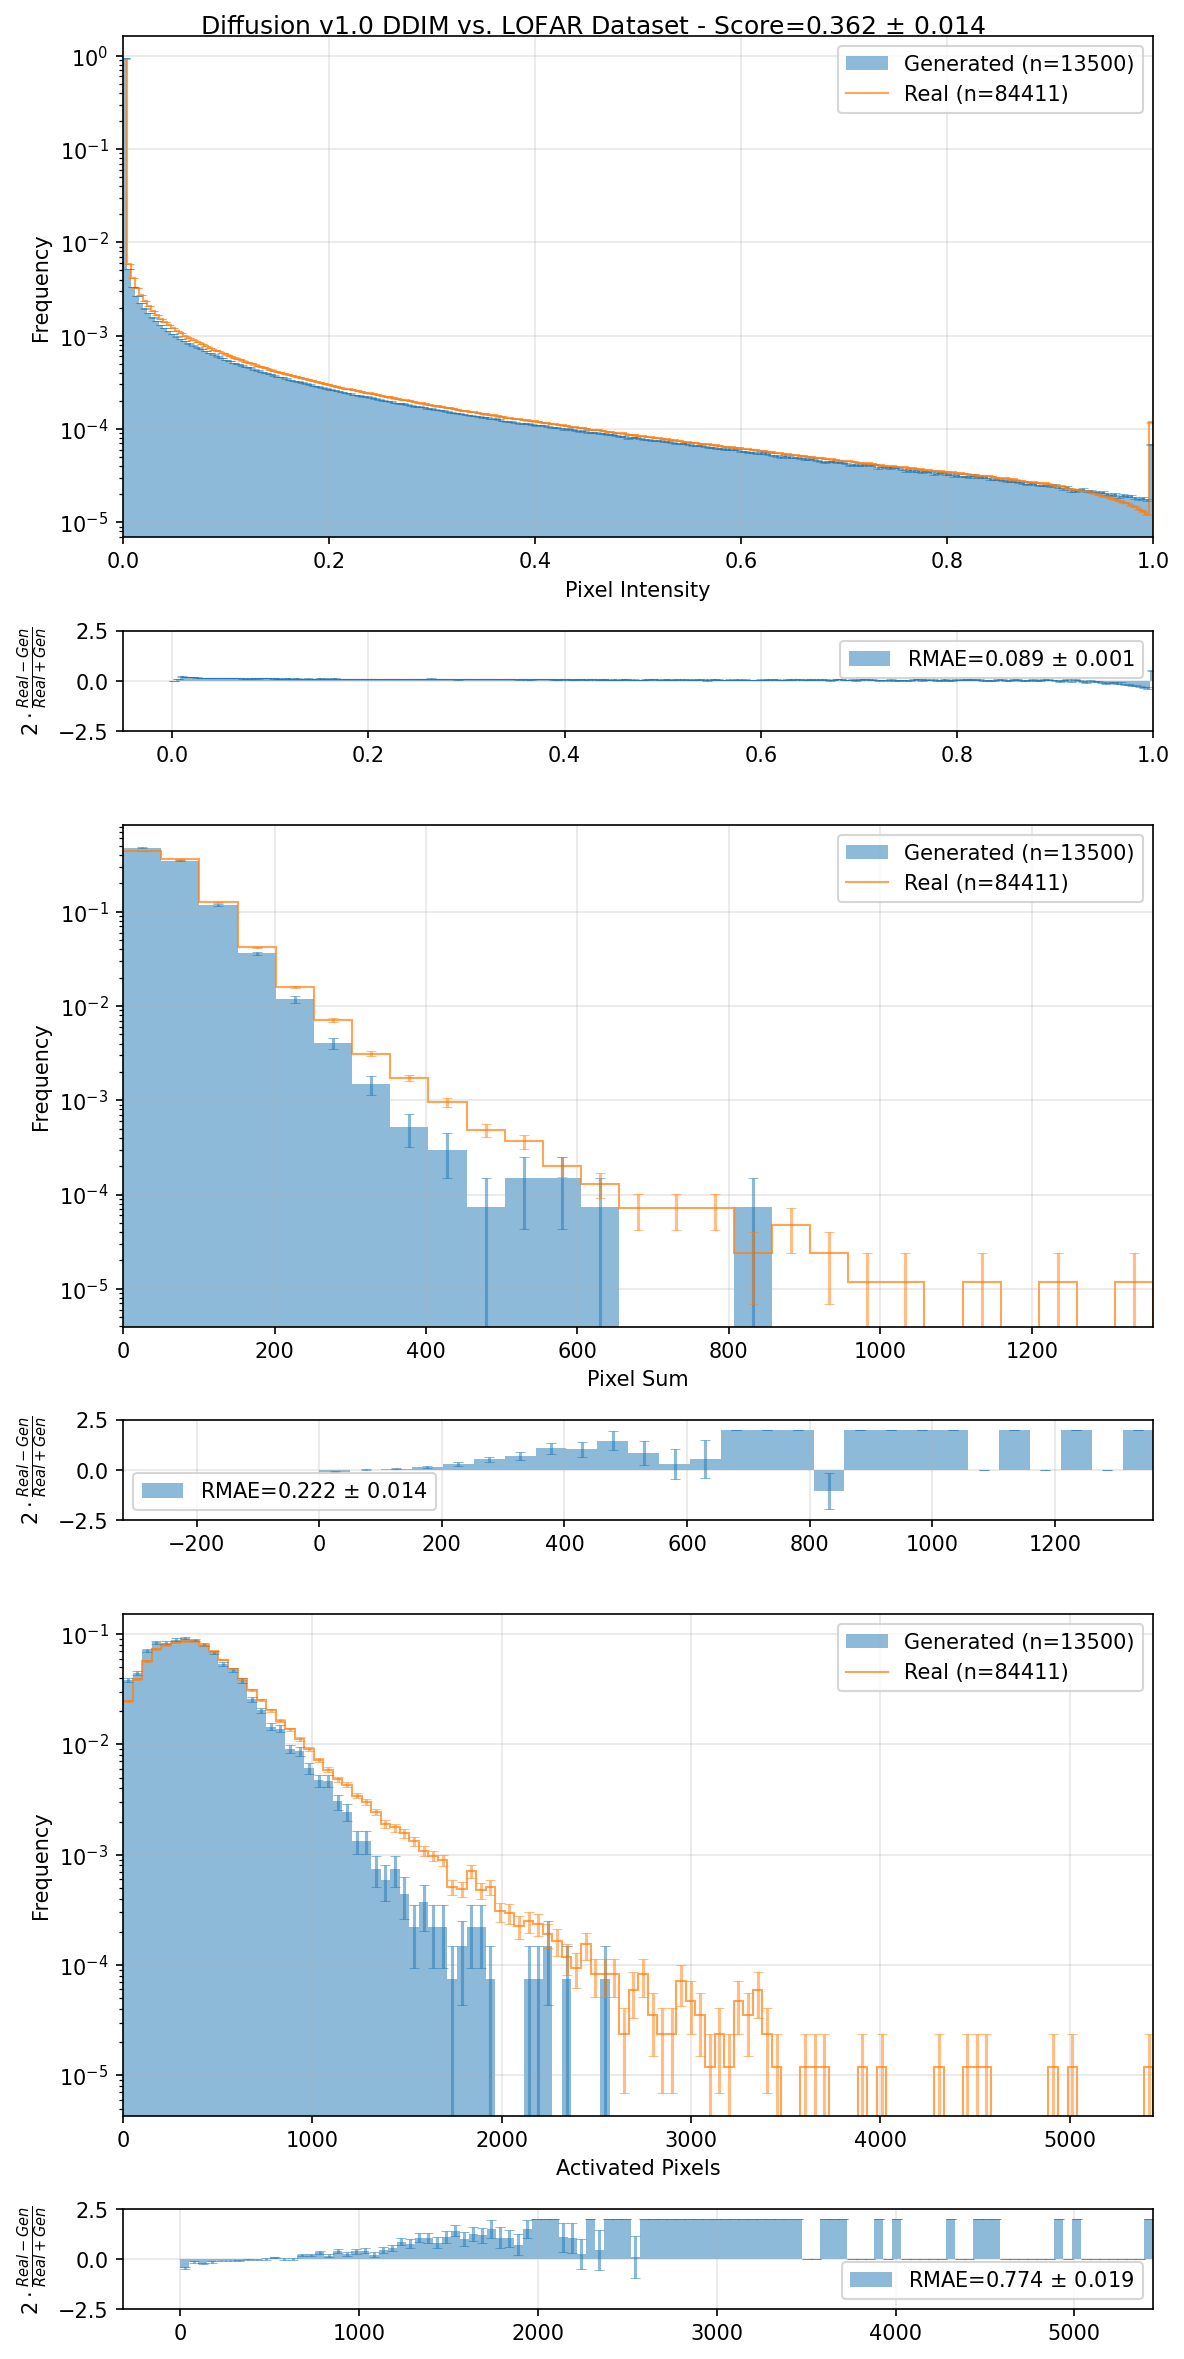

In [16]:
fig, axs = plt.subplots(6, 1, dpi=150, tight_layout=True, figsize=(8, 16),
                        height_ratios=[5,1,5,1,5,1])
get_centers = lambda edges: (edges[1:] + edges[:-1]) / 2

for ax, ax2, key in zip(axs[::2], axs[1::2], distr_lofar.keys()):
    c_gen, e_gen = distr_gen[key]
    norm = torch.sum(c_gen)
    err_gen = torch.sqrt(c_gen)
    ax.stairs(c_gen / norm, e_gen,
              alpha=0.5, fill=True, label=f"Generated (n={len(ds_gen)})",
              color="tab:blue")
    ax.errorbar(get_centers(e_gen), c_gen / norm,
                yerr=err_gen / norm,
                alpha=0.5, ls="none", color="tab:blue",
                capsize=2.5, capthick=0.5)
    
    
    c_lofar, e_lofar = distr_lofar[key]  # Counts, edges
    norm = torch.sum(c_lofar)
    err_lofar = torch.sqrt(c_lofar)
    ax.stairs(c_lofar / c_lofar.sum(), e_lofar,
               alpha=0.7, label=f"Real (n={len(ds_subset)})", color="tab:orange")
    ax.errorbar(get_centers(e_lofar), c_lofar / norm,
                yerr=err_lofar / norm,
                alpha=0.5, ls="none", color="tab:orange",
                capsize=2.5, capthick=0.5)
    
    xmax = torch.max(torch.cat([
        e_gen[1:][c_gen>0], e_lofar[1:][c_lofar>0]
    ])).item()
    ax.set_xlim(left=0, right=xmax)

    ax.set_ylabel("Frequency")
    ax.set_xlabel(key)
    ax.set_yscale("log")
    ax.grid(alpha=0.3)
    ax.legend()

    c, dc_sq, e = error[key]
    ax2.stairs(c, e, fill=True, alpha=0.5,
              label=f"RMAE={rmae[key][0].item():.3f} $\pm$ {torch.sqrt(rmae[key][1]).item():.3f}",
              color="tab:blue")
    ax2.errorbar(get_centers(e), c,
                yerr=torch.sqrt(dc_sq),
                alpha=0.5, ls="none", color="tab:blue",
                capsize=2.5, capthick=0.5)

    ax2.set_ylabel(r"$2 \cdot \frac{Real-Gen}{Real+Gen}$")
    ax2.grid(alpha=0.3)
    ax2.set_xlim(right=xmax)
    ax2.set_ylim(-2.5, 2.5)
    ax2.legend()

title = "Diffusion v1.0 DDIM vs. LOFAR Dataset"
fig.suptitle(f"{title} - Score={rmae['Sum'][0].item():.3f} $\pm$ {torch.sqrt(rmae['Sum'][1]).item():.3f}")
# fig.savefig(f"./analysis/dataset_comparisons/{title.replace('.', '')}.pdf")
fig.show()

Found existing distribution file for diffusion_v1.0.


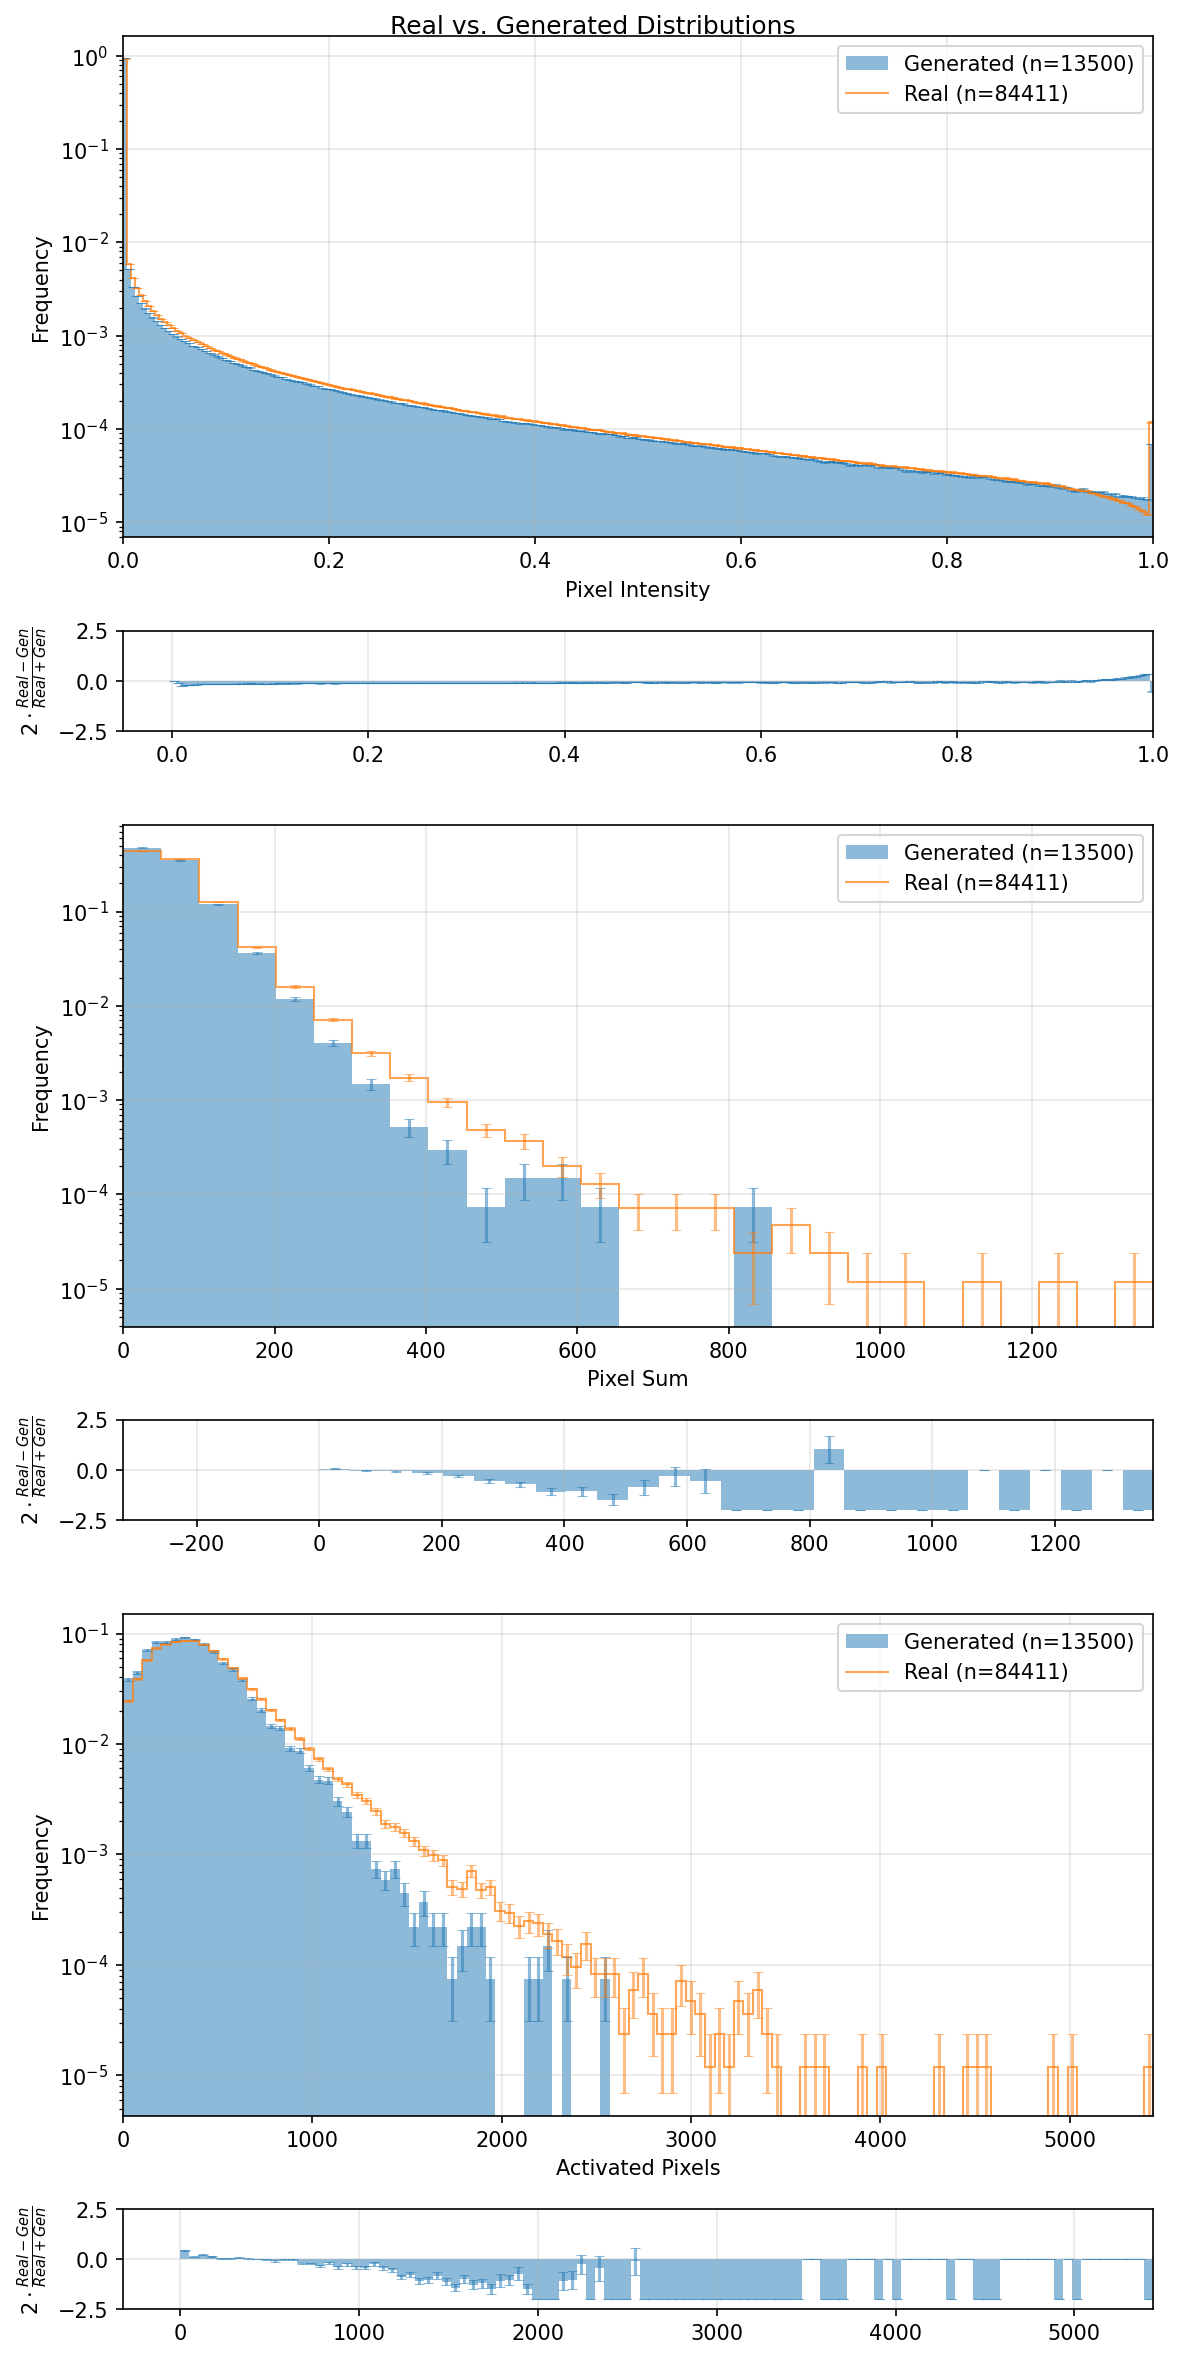

In [3]:
from analysis.model_evaluations import compare_dataset_to_lofar
from pathlib import Path


img_dir = Path("/storage/tmartinez/image_data/generated/diffusion_v1.0")

fig = compare_dataset_to_lofar(img_dir)
fig.show()

## Find closest images

In [98]:
from sklearn.decomposition import PCA
from scipy.ndimage import rotate
import itertools

In [100]:
def align_image(img):
    X = np.array(np.where(img > 0)).T
    # Perform a PCA and compute the angle of the first principal axes
    try:
        pca = PCA(n_components=2).fit(X)
    except ValueError:
        return torch.zeros(1, 80, 80), -1  # If every pixel is 0
    angle = np.arctan2(*pca.components_[0])
    # Rotate the image by the computed angle:
    rotated_img = rotate(img,angle/np.pi*180 - 90, reshape=False)
    return torch.tensor(rotated_img.reshape(1,80,80)), angle/np.pi*180 - 90

def deltas(b1, b2):
    len1, len2 = [b.shape[0] for b in [b1, b2]]
    pairs = list(itertools.product(range(len1), range(len2)))
    deltas = []

    for i, j in tqdm(pairs, desc="Comparing pair-wise..."):
        img1 = align_image(b1[i].squeeze())[0]
        img2 = align_image(b2[j].squeeze())[0]

        diff = (img1 - img2).abs().sum()
        deltas.append(torch.tensor([i, j, diff]))
    
    return torch.vstack(deltas)

def get_pairs(b1, b2, delta, n=10):
    ind = delta[:,-1].argsort(dim=0)
    sorted_pairs = delta[:,:-1][ind][:n]
    imgs = []

    for pair in sorted_pairs:
        i, j = pair
        img1 = b1[int(i)].squeeze()
        img2 = b2[int(j)].squeeze()
        imgs.append(torch.stack([img1, img2]))
    
    return torch.stack(imgs)

def plot_pair(pair, titles):
    fig = plt.figure()
    for i, (img, title) in enumerate(zip(pair, titles)):
        ax = fig.add_subplot(1, 2, i+1)
        ax.imshow(img, vmin=0, vmax=1)
        ax.set_title(title)
    return fig


torch.Size([500, 1, 80, 80]) torch.Size([500, 1, 80, 80])
torch.Size([4, 1, 80, 80]) torch.Size([11, 1, 80, 80])


Comparing pair-wise...: 100%|██████████| 44/44 [00:00<00:00, 480.24it/s]


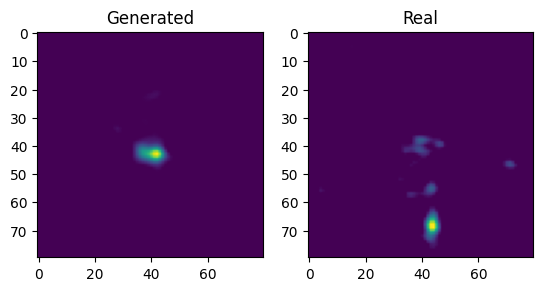

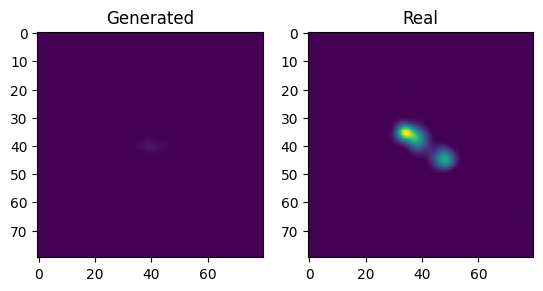

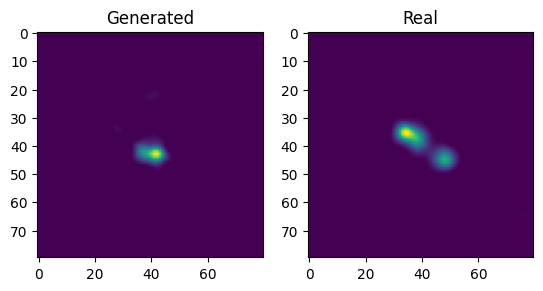

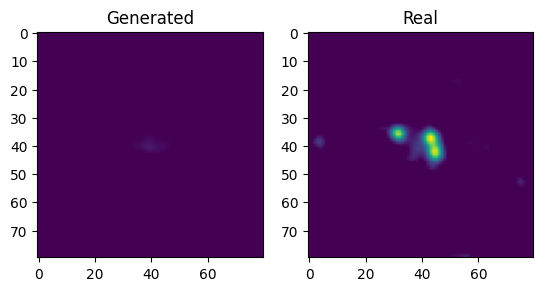

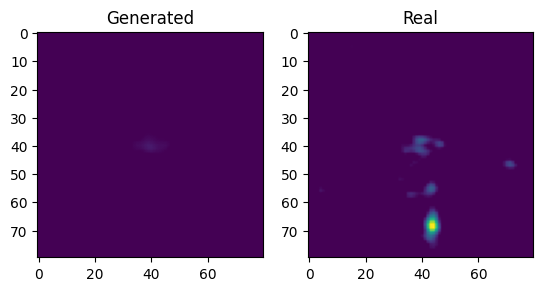

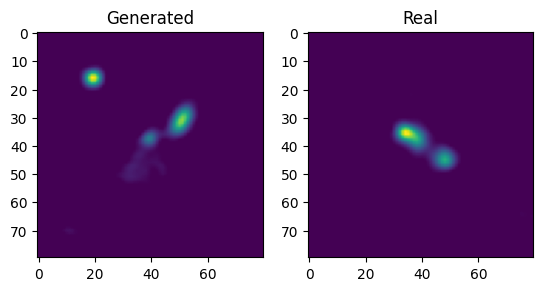

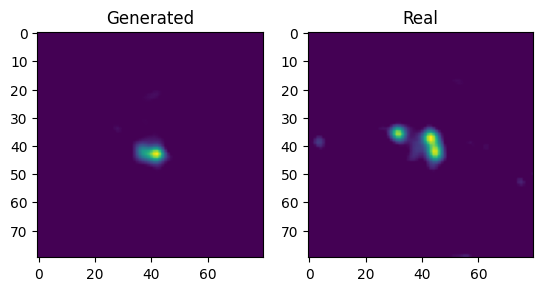

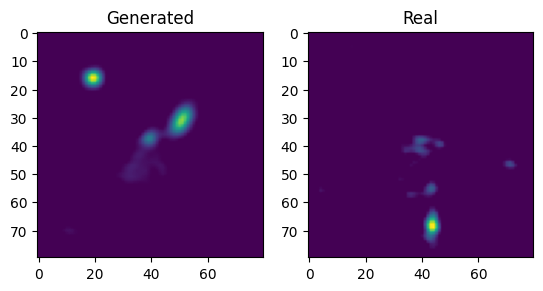

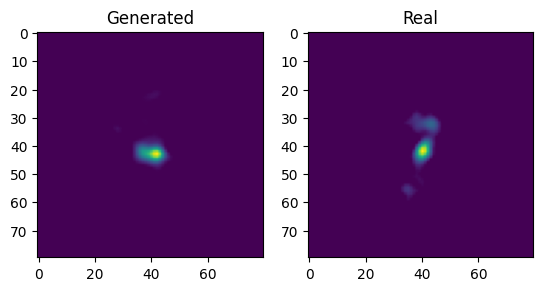

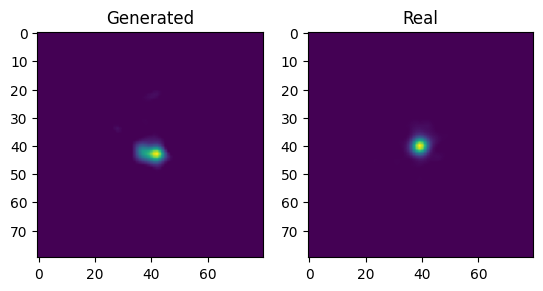

In [128]:
get_dl = lambda ds: DataLoader(ds, batch_size=500, shuffle=True)

dl_lofar = get_dl(ds_lofar)
dl_gen = get_dl(ds_gen)

b_gen = next(iter(dl_gen))
b_lofar = next(iter(dl_lofar))

print(b_gen.shape, b_lofar.shape)

get_active = lambda b: b[(b.sum(dim=(1, 2, 3)) > 250).nonzero().squeeze()]

active_gen, active_lofar = get_active(b_gen), get_active(b_lofar)

print(active_gen.shape, active_lofar.shape)

delta = deltas(active_gen, active_lofar)
pairs = get_pairs(b_gen, b_lofar, delta, n=100)

for pair in pairs[:10]:
    fig = plot_pair(pair, titles=["Generated", "Real"])
    fig.show()